### Ejercicio MILP 06: Sudoku

Se desea resolver un sudoku mediante técnicas de optimización entera

(Ejemplo adaptado de https://medium.com/@dhanalakotamohan314/creating-sudoku-solver-with-python-and-pyomo-in-easy-steps-fe22ec916090)

#### Variables
Se plantean variables con tres dimensiones: *i* hace referencia a la posición de la fila (1-9), *j* hace referencia a la posición de la columna (1-9) y *k* es una variable binaria que indica si los números 1 a 9 están o no están (0-1) en dicha posición. Vamos a definir una variable *q* que hace referencia a cada uno de los tres bloques en cada columna en los que no se pueden repetir los números y una variable *p* que hace lo mismos en los tres bloques de cada fila. 

#### Restricciones
En primer lugar, queremos que los números no se repitan ni en las filas ni en las columnas:
$$
\sum_{i=1}^9 x_{ijk} =1 \quad  \text{for} \quad j,k \in \quad [1-9] \\
\sum_{j=1}^9 x_{ijk} =1 \quad  \text{for} \quad i,k \in \quad [1-9]
$$
Tampoco se desea que se repita un número en cada uno de los 9 bloques (*q·p*) en los que se divide la cuadrícula. 

$$
\sum_{j=3p-2}^{3p} \sum_{i=3q-2}^{3q} x_{ijk}=1 \quad  \text{for} \quad k  \in  [1-9] \quad \text{and} \quad  p,q \in  [1-3]
$$

Por último, no se desea tampoco dejar ninguna celda sin un número:

$$
\sum_{k=1}^{n} x_{ijk}=1 \quad  \text{for} \quad i,j  \in  [1-9]
$$

En este caso, es irrelevante el objetivo, puesto que lo que queremos es simplemente una solución que cumpla las restricciones:

$$
FO = 1
$$

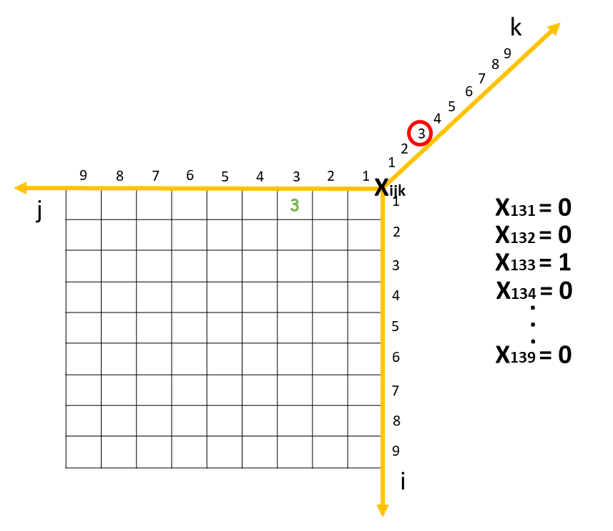

In [5]:
from IPython.display import Image 
Image(filename='img_enun/sudoku.png', width= 400)

In [6]:
from pyomo.environ import *
import numpy as np
import pandas as pd

model=ConcreteModel()
N = np.arange(1,10) #vector de 1 a 9 (para filas, columnas y números)
model.X = Var(N, N, N, within = Binary)

In [7]:
## Filas
model.row_constr = ConstraintList()
for i in N:
    for k in N:
        model.row_constr.add(sum(model.X[i, j, k] for j in N)==1)
        
## Columnas
model.col_constr = ConstraintList()
for j in N:
    for k in N:
        model.col_constr.add(sum(model.X[i, j, k] for i in N)==1)
        
## Bloques
model.block_constr = ConstraintList()
for i in np.arange(1,9,3): #
    for j in np.arange(1,9,3):
        for k in N:
            model.block_constr.add(sum(model.X[p, q, k] for p in np.arange(i, i+3) for q in np.arange(j, j+3))==1)
            
## Todas las celdas con número
model.allCell_constr = ConstraintList()
for i in N:
    for j in N:
        model.allCell_constr.add(1 == sum(model.X[i, j, k] for k in N))

## Función objetivo
model.Obj = Objective(expr = 1)

results = SolverFactory('glpk').solve(model).write()


    solver failure.
# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 1.0
  Upper bound: 1.0
  Number of objectives: 1
  Number of constraints: 325
  Number of variables: 730
  Number of nonzeros: 2917
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 177
      Number of created subproblems: 177
  Error rc: 0
  Time: 0.784160852432251
# ----------------------------------------------------------
#   Solution Information
# ------------

In [8]:
solutionDf = pd.DataFrame({
'i': [i[0] for i in model.X.keys()], 
'j': [i[1] for i in model.X.keys()], 
'k': [i[2] for i in model.X.keys()], 
'assignment': [i.value for i in model.X.values()]})
solutionDf = solutionDf[solutionDf['assignment'] == 1]
solutionDf.pivot(index = 'i', columns = 'j', values = 'k')

j,1,2,3,4,5,6,7,8,9
i,,,,,,,,,
1,3,1,5,4,8,6,9,2,7
2,6,7,8,1,9,2,3,5,4
3,9,2,4,5,3,7,8,1,6
4,2,4,3,6,1,9,5,7,8
5,7,8,1,3,4,5,2,6,9
6,5,9,6,7,2,8,4,3,1
7,4,3,2,9,7,1,6,8,5
8,1,5,9,8,6,3,7,4,2
9,8,6,7,2,5,4,1,9,3
